# Module 4 - Lesson 3: Categorical Encoding

## From Categories to Numbers: Essential Techniques for Machine Learning

Welcome to Lesson 3! This notebook will teach you how to convert categorical variables (text/labels) into numbers that machine learning algorithms can understand. This is a critical skill - get it wrong and your model will either fail or learn incorrect patterns.

### What You'll Learn:
- Why encoding categorical variables is challenging
- One-hot encoding for nominal categories
- Label encoding and when it's appropriate
- Target encoding for high-cardinality features
- Handling unknown categories in production
- Common pitfalls and how to avoid them

### Why This Matters:
Machine learning models need numbers, not text. But converting 'red', 'blue', 'green' to 1, 2, 3 implies that green > blue > red, which is wrong! We need smarter encoding strategies that preserve the meaning of our categorical data.

## Setup: Import Required Libraries

Let's start by importing all the libraries we'll need for this lesson:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Understanding the Encoding Challenge

### The Fundamental Problem

Machine learning algorithms work with numbers, but much of our data is categorical (text labels). Simply converting categories to numbers can create problems because numbers have properties that categories don't:
- **Order**: 3 > 2 > 1
- **Distance**: 3 - 1 = 2
- **Mathematical operations**: (1 + 3) / 2 = 2

Let's see why naive encoding doesn't work:

In [2]:
# Create sample categorical data
df = pd.DataFrame({
    'color': ['red', 'blue', 'green', 'red', 'blue', 'green', 'red'],
    'size': ['small', 'medium', 'large', 'medium', 'small', 'large', 'medium'],
    'quality': ['good', 'excellent', 'poor', 'good', 'excellent', 'good', 'poor'],
    'price': [100, 150, 200, 120, 140, 180, 90]
})

print("Original categorical data:")
print(df)
print("\nData types:")
print(df.dtypes)

Original categorical data:
   color    size    quality  price
0    red   small       good    100
1   blue  medium  excellent    150
2  green   large       poor    200
3    red  medium       good    120
4   blue   small  excellent    140
5  green   large       good    180
6    red  medium       poor     90

Data types:
color      object
size       object
quality    object
price       int64
dtype: object


### The Naive Approach - Why It's Wrong

Let's see what happens if we simply assign numbers to categories:

In [3]:
# Naive encoding - DON'T DO THIS for nominal categories!
naive_encoding = {
    'red': 1,
    'blue': 2,
    'green': 3
}

df['color_naive'] = df['color'].map(naive_encoding)

print("Naive encoding of colors:")
print(df[['color', 'color_naive']])
print("\n⚠️ PROBLEMS with this approach:")
print("1. Implies green (3) > blue (2) > red (1)")
print("2. Suggests green is 3x more than red")
print("3. Distance between green-red = 2, blue-red = 1")
print("4. Model might learn that (red + green) / 2 = blue!")

# Clean up
df = df.drop('color_naive', axis=1)

Naive encoding of colors:
   color  color_naive
0    red            1
1   blue            2
2  green            3
3    red            1
4   blue            2
5  green            3
6    red            1

⚠️ PROBLEMS with this approach:
1. Implies green (3) > blue (2) > red (1)
2. Suggests green is 3x more than red
3. Distance between green-red = 2, blue-red = 1
4. Model might learn that (red + green) / 2 = blue!


### Types of Categorical Variables

Before encoding, we need to understand what type of categorical variable we have:

1. **Nominal**: No inherent order (colors, countries, product types)
2. **Ordinal**: Natural ordering (small/medium/large, poor/good/excellent)
3. **Binary**: Two categories (yes/no, true/false)
4. **High Cardinality**: Many unique values (zip codes, product IDs)

In [4]:
# Identify different types of categorical variables
print("Analyzing our categorical variables:")
print("=" * 50)

for col in ['color', 'size', 'quality']:
    unique_values = df[col].unique()
    n_unique = len(unique_values)
    
    print(f"\n{col}:")
    print(f"  Unique values: {unique_values}")
    print(f"  Count: {n_unique}")
    
    if col == 'color':
        print("  Type: NOMINAL (no natural order)")
        print("  Recommended encoding: One-Hot")
    elif col == 'size':
        print("  Type: ORDINAL (small < medium < large)")
        print("  Recommended encoding: Ordinal/Label")
    elif col == 'quality':
        print("  Type: ORDINAL (poor < good < excellent)")
        print("  Recommended encoding: Ordinal with custom mapping")

Analyzing our categorical variables:

color:
  Unique values: ['red' 'blue' 'green']
  Count: 3
  Type: NOMINAL (no natural order)
  Recommended encoding: One-Hot

size:
  Unique values: ['small' 'medium' 'large']
  Count: 3
  Type: ORDINAL (small < medium < large)
  Recommended encoding: Ordinal/Label

quality:
  Unique values: ['good' 'excellent' 'poor']
  Count: 3
  Type: ORDINAL (poor < good < excellent)
  Recommended encoding: Ordinal with custom mapping


## 2. One-Hot Encoding

### How One-Hot Encoding Works

One-hot encoding creates a new binary column for each category. Only one column has a 1 (hot) while others have 0 (cold).

This is perfect for **nominal categories** where there's no inherent order.

Example: `color = red` becomes `color_red = 1, color_blue = 0, color_green = 0`

In [5]:
# Method 1: Using pandas get_dummies (easiest for exploration)
df_with_dummies = pd.get_dummies(df, columns=['color'], prefix='color')

print("One-hot encoding using pandas get_dummies:")
print(df_with_dummies.head())
print("\n✅ Notice: Each color is now a separate binary column")
print("✅ No false ordering is implied")
print("✅ Each row has exactly one 1 across the color columns")

One-hot encoding using pandas get_dummies:
     size    quality  price  color_blue  color_green  color_red
0   small       good    100       False        False       True
1  medium  excellent    150        True        False      False
2   large       poor    200       False         True      False
3  medium       good    120       False        False       True
4   small  excellent    140        True        False      False

✅ Notice: Each color is now a separate binary column
✅ No false ordering is implied
✅ Each row has exactly one 1 across the color columns


### Using Scikit-learn's OneHotEncoder

For production and pipelines, scikit-learn's OneHotEncoder is more robust:

In [6]:
from sklearn.preprocessing import OneHotEncoder

# Create and fit the encoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
color_encoded = ohe.fit_transform(df[['color']])

# Get feature names
feature_names = ohe.get_feature_names_out(['color'])

# Create DataFrame with encoded features
color_encoded_df = pd.DataFrame(color_encoded, columns=feature_names)

print("One-hot encoding using scikit-learn:")
print(color_encoded_df.head())
print("\nEncoder categories:", ohe.categories_[0])
print("\n💡 Advantage: handle_unknown='ignore' prevents errors with new categories in production")

One-hot encoding using scikit-learn:
   color_blue  color_green  color_red
0         0.0          0.0        1.0
1         1.0          0.0        0.0
2         0.0          1.0        0.0
3         0.0          0.0        1.0
4         1.0          0.0        0.0

Encoder categories: ['blue' 'green' 'red']

💡 Advantage: handle_unknown='ignore' prevents errors with new categories in production


### The Dummy Variable Trap

When using one-hot encoding with linear models, you might encounter the **dummy variable trap** - perfect multicollinearity. We can avoid this by dropping one column:

In [7]:
# Demonstrate dummy variable trap
print("Full one-hot encoding (can cause issues with linear models):")
print(color_encoded_df.head())
print(f"Shape: {color_encoded_df.shape}")
print("\nSum of each row (always 1):")
print(color_encoded_df.sum(axis=1).unique())

# Drop first column to avoid dummy variable trap
ohe_drop = OneHotEncoder(sparse_output=False, drop='first')
color_encoded_drop = ohe_drop.fit_transform(df[['color']])
color_encoded_drop_df = pd.DataFrame(
    color_encoded_drop, 
    columns=ohe_drop.get_feature_names_out(['color'])
)

print("\nWith drop='first' (n-1 encoding):")
print(color_encoded_drop_df.head())
print(f"Shape: {color_encoded_drop_df.shape}")
print("\n📝 Note: 'blue' is dropped. When all other columns are 0, it means 'blue'")
print("This prevents multicollinearity in linear models while preserving all information")

Full one-hot encoding (can cause issues with linear models):
   color_blue  color_green  color_red
0         0.0          0.0        1.0
1         1.0          0.0        0.0
2         0.0          1.0        0.0
3         0.0          0.0        1.0
4         1.0          0.0        0.0
Shape: (7, 3)

Sum of each row (always 1):
[1.]

With drop='first' (n-1 encoding):
   color_green  color_red
0          0.0        1.0
1          0.0        0.0
2          1.0        0.0
3          0.0        1.0
4          0.0        0.0
Shape: (7, 2)

📝 Note: 'blue' is dropped. When all other columns are 0, it means 'blue'
This prevents multicollinearity in linear models while preserving all information


### When to Use One-Hot Encoding

**Use One-Hot when:**
- Nominal categories (no natural order)
- Low to medium cardinality (< 10-20 categories)
- Linear models, neural networks, SVM

**Don't use when:**
- High cardinality (100s of categories) - causes dimensionality explosion
- Tree-based models with many categories (they can handle label encoding)
- Memory is a constraint

## 3. Label Encoding and Ordinal Encoding

### Label Encoding for Ordinal Variables

When categories have a natural order, we can use label encoding. But we need to be careful to preserve the correct order!

In [8]:
# For ordinal data, we need to specify the order
size_order = ['small', 'medium', 'large']
quality_order = ['poor', 'good', 'excellent']

# Method 1: Using pandas Categorical
df['size_encoded'] = pd.Categorical(
    df['size'], 
    categories=size_order, 
    ordered=True
).codes

df['quality_encoded'] = pd.Categorical(
    df['quality'], 
    categories=quality_order, 
    ordered=True
).codes

print("Ordinal encoding with correct order:")
print(df[['size', 'size_encoded', 'quality', 'quality_encoded']])
print("\n✅ Notice: small=0 < medium=1 < large=2")
print("✅ Notice: poor=0 < good=1 < excellent=2")
print("The ordering now makes sense!")

Ordinal encoding with correct order:
     size  size_encoded    quality  quality_encoded
0   small             0       good                1
1  medium             1  excellent                2
2   large             2       poor                0
3  medium             1       good                1
4   small             0  excellent                2
5   large             2       good                1
6  medium             1       poor                0

✅ Notice: small=0 < medium=1 < large=2
✅ Notice: poor=0 < good=1 < excellent=2
The ordering now makes sense!


### Using Scikit-learn's OrdinalEncoder

For production pipelines, OrdinalEncoder is more robust:

In [9]:
from sklearn.preprocessing import OrdinalEncoder

# Create encoder with specified order
ordinal_encoder = OrdinalEncoder(
    categories=[size_order],
    handle_unknown='use_encoded_value',
    unknown_value=-1  # Unknown categories will be encoded as -1
)

# Fit and transform
df['size_ordinal'] = ordinal_encoder.fit_transform(df[['size']])

print("Ordinal encoding with scikit-learn:")
print(df[['size', 'size_ordinal']])

# Test with unknown category
new_data = pd.DataFrame({'size': ['small', 'extra-large', 'medium']})
new_encoded = ordinal_encoder.transform(new_data[['size']])

print("\nHandling unknown categories:")
print("Original:", new_data['size'].values)
print("Encoded:", new_encoded.ravel())
print("\n📝 'extra-large' is unknown, encoded as -1")

Ordinal encoding with scikit-learn:
     size  size_ordinal
0   small           0.0
1  medium           1.0
2   large           2.0
3  medium           1.0
4   small           0.0
5   large           2.0
6  medium           1.0

Handling unknown categories:
Original: ['small' 'extra-large' 'medium']
Encoded: [ 0. -1.  1.]

📝 'extra-large' is unknown, encoded as -1


### Custom Mapping for More Control

Sometimes you want specific numeric values for your ordinal categories:

In [10]:
# Custom mapping with specific values
quality_mapping = {
    'poor': 1,
    'good': 5,
    'excellent': 10
}

df['quality_custom'] = df['quality'].map(quality_mapping)

print("Custom mapping for quality:")
print(df[['quality', 'quality_encoded', 'quality_custom']])
print("\n📝 Custom mapping allows non-uniform spacing")
print("This can reflect domain knowledge (excellent is much better than good)")

Custom mapping for quality:
     quality  quality_encoded  quality_custom
0       good                1               5
1  excellent                2              10
2       poor                0               1
3       good                1               5
4  excellent                2              10
5       good                1               5
6       poor                0               1

📝 Custom mapping allows non-uniform spacing
This can reflect domain knowledge (excellent is much better than good)


### Binary Encoding (Special Case)

For binary categories, simple 0/1 encoding is sufficient:

In [11]:
# Add binary column
df['is_premium'] = np.random.choice(['yes', 'no'], size=len(df))

# Simple binary encoding
df['is_premium_encoded'] = (df['is_premium'] == 'yes').astype(int)

# Alternative using LabelEncoder
le = LabelEncoder()
df['is_premium_label'] = le.fit_transform(df['is_premium'])

print("Binary encoding:")
print(df[['is_premium', 'is_premium_encoded', 'is_premium_label']].head())
print("\n✅ For binary categories, 0/1 encoding is perfect")
print("No information loss, no dimensionality increase")

Binary encoding:
  is_premium  is_premium_encoded  is_premium_label
0        yes                   1                 1
1         no                   0                 0
2        yes                   1                 1
3        yes                   1                 1
4        yes                   1                 1

✅ For binary categories, 0/1 encoding is perfect
No information loss, no dimensionality increase


## 4. Target Encoding (Mean Encoding)

### Handling High Cardinality Features

When you have categorical features with many unique values (like zip codes, product IDs), one-hot encoding creates too many columns. Target encoding replaces each category with the mean of the target variable for that category.

⚠️ **WARNING**: Target encoding can cause overfitting if not done carefully!

In [12]:
# Create high cardinality example
np.random.seed(42)
n_samples = 1000

# High cardinality feature (50 different cities)
cities = [f'City_{i}' for i in range(50)]
df_high_card = pd.DataFrame({
    'city': np.random.choice(cities, n_samples),
    'features': np.random.randn(n_samples),
    'target': np.random.randint(0, 2, n_samples)
})

print(f"High cardinality data:")
print(f"Number of unique cities: {df_high_card['city'].nunique()}")
print(f"Dataset size: {len(df_high_card)}")
print("\nFirst few rows:")
print(df_high_card.head())

High cardinality data:
Number of unique cities: 50
Dataset size: 1000

First few rows:
      city  features  target
0  City_38 -0.617090       1
1  City_28 -1.258842       0
2  City_14  1.188801       1
3  City_42 -0.041308       1
4   City_7  0.173966       1


### Implementing Target Encoding

Let's implement target encoding properly with cross-validation to avoid data leakage:

In [13]:
class TargetEncoder:
    """Target encoder with smoothing to prevent overfitting"""
    
    def __init__(self, smoothing=1.0):
        self.smoothing = smoothing
        self.encodings = {}
        self.global_mean = None
        
    def fit(self, X, y):
        """Calculate target statistics for each category"""
        # Global mean of target
        self.global_mean = y.mean()
        
        # Calculate statistics for each category
        for category in X.unique():
            mask = X == category
            category_target = y[mask]
            
            # Number of samples in this category
            n = len(category_target)
            
            # Category mean
            category_mean = category_target.mean()
            
            # Smoothed estimate (shrinkage towards global mean)
            smoothed_mean = (
                (category_mean * n + self.global_mean * self.smoothing) / 
                (n + self.smoothing)
            )
            
            self.encodings[category] = smoothed_mean
            
        return self
        
    def transform(self, X):
        """Transform categories to target encodings"""
        # Use global mean for unknown categories
        return X.map(self.encodings).fillna(self.global_mean)
    
    def fit_transform(self, X, y):
        """Fit and transform in one step"""
        return self.fit(X, y).transform(X)


# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df_high_card[['city', 'features']], 
    df_high_card['target'], 
    test_size=0.2, 
    random_state=42
)

# Apply target encoding
encoder = TargetEncoder(smoothing=5.0)
X_train_encoded = X_train.copy()
X_train_encoded['city_encoded'] = encoder.fit_transform(X_train['city'], y_train)

X_test_encoded = X_test.copy()
X_test_encoded['city_encoded'] = encoder.transform(X_test['city'])

print("Target encoding results:")
print("\nTraining set (first 10 rows):")
print(X_train_encoded[['city', 'city_encoded']].head(10))

print("\nEncoding statistics:")
print(f"Global mean: {encoder.global_mean:.3f}")
print(f"Number of encoded categories: {len(encoder.encodings)}")
print(f"Encoding range: [{min(encoder.encodings.values()):.3f}, {max(encoder.encodings.values()):.3f}]")

Target encoding results:

Training set (first 10 rows):
        city  city_encoded
29   City_48      0.413043
535  City_42      0.633333
695  City_12      0.605263
557  City_28      0.477273
836  City_46      0.446429
596  City_40      0.575000
165  City_12      0.605263
918  City_26      0.472222
495   City_4      0.410714
824  City_25      0.650000

Encoding statistics:
Global mean: 0.500
Number of encoded categories: 50
Encoding range: [0.325, 0.679]


### Visualizing Target Encoding Effect

Let's visualize how target encoding captures the relationship between categories and the target:

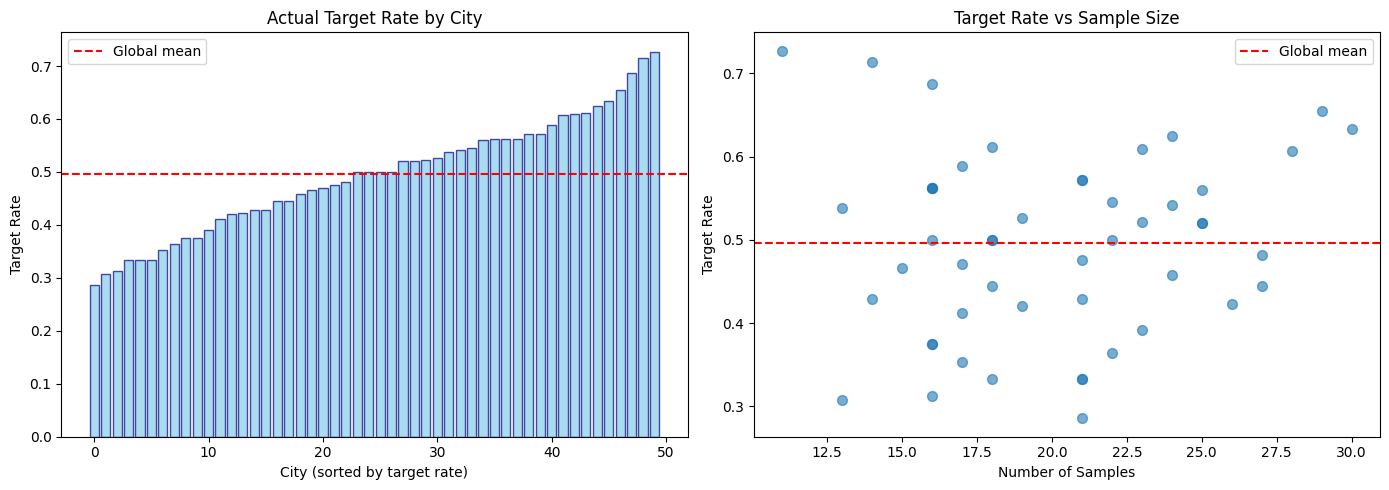

📝 Key observations:
- Cities have different target rates (encoding captures this)
- Small sample sizes lead to extreme values (smoothing helps)
- Target encoding converts 50 categories to 1 meaningful number


In [14]:
# Calculate actual target rates for each city
city_stats = df_high_card.groupby('city')['target'].agg(['mean', 'count']).reset_index()
city_stats = city_stats.sort_values('mean')

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Target rate by city
axes[0].bar(range(len(city_stats)), city_stats['mean'], color='skyblue', edgecolor='navy', alpha=0.7)
axes[0].axhline(y=df_high_card['target'].mean(), color='red', linestyle='--', label='Global mean')
axes[0].set_xlabel('City (sorted by target rate)')
axes[0].set_ylabel('Target Rate')
axes[0].set_title('Actual Target Rate by City')
axes[0].legend()

# Sample size effect
axes[1].scatter(city_stats['count'], city_stats['mean'], alpha=0.6, s=50)
axes[1].axhline(y=df_high_card['target'].mean(), color='red', linestyle='--', label='Global mean')
axes[1].set_xlabel('Number of Samples')
axes[1].set_ylabel('Target Rate')
axes[1].set_title('Target Rate vs Sample Size')
axes[1].legend()

plt.tight_layout()
plt.show()

print("📝 Key observations:")
print("- Cities have different target rates (encoding captures this)")
print("- Small sample sizes lead to extreme values (smoothing helps)")
print("- Target encoding converts 50 categories to 1 meaningful number")

### Preventing Overfitting with K-Fold Target Encoding

For even better results, use K-fold cross-validation during encoding:

In [15]:
from sklearn.model_selection import KFold

def kfold_target_encoding(X, y, n_splits=5, smoothing=1.0):
    """K-fold target encoding to prevent overfitting"""
    
    # Initialize encoded array
    X_encoded = np.zeros(len(X))
    
    # Global mean for smoothing
    global_mean = y.mean()
    
    # K-fold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(X):
        # Split data
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        
        # Fit encoder on training fold
        encoder = TargetEncoder(smoothing=smoothing)
        encoder.fit(X_train_fold, y_train_fold)
        
        # Transform validation fold
        X_encoded[val_idx] = encoder.transform(X_val_fold)
    
    return X_encoded

# Apply K-fold target encoding
X_train_kfold = X_train.copy()
X_train_kfold['city_kfold_encoded'] = kfold_target_encoding(
    X_train['city'], 
    y_train, 
    n_splits=5, 
    smoothing=5.0
)

print("K-fold target encoding (prevents overfitting):")
print(X_train_kfold[['city', 'city_kfold_encoded']].head(10))
print("\n✅ Each sample is encoded using out-of-fold statistics")
print("✅ This prevents data leakage and reduces overfitting")

K-fold target encoding (prevents overfitting):
        city  city_kfold_encoded
29   City_48            0.356399
535  City_42            0.592330
695  City_12            0.608817
557  City_28            0.471354
836  City_46            0.500744
596  City_40            0.524740
165  City_12            0.560662
918  City_26            0.543620
495   City_4            0.377812
824  City_25            0.642113

✅ Each sample is encoded using out-of-fold statistics
✅ This prevents data leakage and reduces overfitting


## 5. Comparing Encoding Methods

### Impact on Different Algorithms

Let's compare how different encoding methods affect various machine learning algorithms:

In [16]:
# Create a dataset with mixed categorical types
np.random.seed(42)
n = 1000

df_comparison = pd.DataFrame({
    'nominal': np.random.choice(['A', 'B', 'C'], n),
    'ordinal': np.random.choice(['low', 'medium', 'high'], n),
    'high_card': np.random.choice([f'Cat_{i}' for i in range(30)], n),
    'numeric': np.random.randn(n),
    'target': np.random.randint(0, 2, n)
})

# Split data
X = df_comparison.drop('target', axis=1)
y = df_comparison['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dataset for comparison:")
print(df_comparison.head())
print(f"\nShape: {df_comparison.shape}")
print(f"Nominal categories: {df_comparison['nominal'].nunique()}")
print(f"Ordinal categories: {df_comparison['ordinal'].nunique()}")
print(f"High cardinality categories: {df_comparison['high_card'].nunique()}")

Dataset for comparison:
  nominal ordinal high_card   numeric  target
0       C    high    Cat_13 -0.167122       0
1       A    high     Cat_3  0.282580       1
2       C    high    Cat_12 -0.248691       0
3       C    high     Cat_7  1.607346       0
4       A     low    Cat_28  0.490975       0

Shape: (1000, 5)
Nominal categories: 3
Ordinal categories: 3
High cardinality categories: 30


### Encoding Pipeline Comparison

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Method 1: One-hot for all categoricals
def create_onehot_pipeline():
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', ['numeric']),
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['nominal', 'ordinal', 'high_card'])
        ])
    return preprocessor

# Method 2: Mixed encoding
def create_mixed_pipeline():
    # Create ordinal encoder for ordinal variable
    ordinal_encoder = OrdinalEncoder(
        categories=[['low', 'medium', 'high']],
        handle_unknown='use_encoded_value',
        unknown_value=-1
    )
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', ['numeric']),
            ('nominal', OneHotEncoder(handle_unknown='ignore'), ['nominal']),
            ('ordinal', ordinal_encoder, ['ordinal']),
            ('high_card', 'passthrough', ['high_card'])  # Will use target encoding
        ])
    return preprocessor

# Method 3: Label encoding for trees
def create_label_pipeline():
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', ['numeric']),
            ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
             ['nominal', 'ordinal', 'high_card'])
        ])
    return preprocessor

print("Three encoding strategies created:")
print("1. One-hot for all (high dimensionality)")
print("2. Mixed: One-hot + Ordinal + Target encoding")
print("3. Label encoding for all (for tree models)")

Three encoding strategies created:
1. One-hot for all (high dimensionality)
2. Mixed: One-hot + Ordinal + Target encoding
3. Label encoding for all (for tree models)


### Performance Comparison

In [18]:
# Test different combinations
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

encodings = {
    'One-Hot': create_onehot_pipeline(),
    'Label': create_label_pipeline()
}

results = []

for encoding_name, preprocessor in encodings.items():
    # Transform data
    X_train_encoded = preprocessor.fit_transform(X_train)
    X_test_encoded = preprocessor.transform(X_test)
    
    for model_name, model in models.items():
        # Train and evaluate
        model.fit(X_train_encoded, y_train)
        score = model.score(X_test_encoded, y_test)
        
        results.append({
            'Encoding': encoding_name,
            'Model': model_name,
            'Accuracy': score,
            'Features': X_train_encoded.shape[1]
        })

results_df = pd.DataFrame(results)
pivot_results = results_df.pivot(index='Model', columns='Encoding', values='Accuracy')

print("Performance Comparison:")
print(pivot_results.round(3))
print("\n📊 Feature counts:")
print(results_df.drop_duplicates('Encoding')[['Encoding', 'Features']])
print("\n📝 Key insights:")
print("- Tree-based models work well with label encoding")
print("- Linear models prefer one-hot encoding")
print("- One-hot creates many more features")

Performance Comparison:
Encoding             Label  One-Hot
Model                              
Decision Tree        0.465    0.440
Logistic Regression  0.465    0.515
Random Forest        0.490    0.500

📊 Feature counts:
  Encoding  Features
0  One-Hot        37
3    Label         4

📝 Key insights:
- Tree-based models work well with label encoding
- Linear models prefer one-hot encoding
- One-hot creates many more features


## 6. Production Considerations

### Handling Unknown Categories

In production, you'll encounter categories that weren't in your training data. Here's how to handle them:

In [19]:
# Training data with known categories
train_data = pd.DataFrame({
    'color': ['red', 'blue', 'green'] * 30,
    'size': ['S', 'M', 'L'] * 30
})

# Production data with unknown categories
prod_data = pd.DataFrame({
    'color': ['red', 'yellow', 'blue', 'purple'],  # yellow and purple are new!
    'size': ['S', 'XL', 'M', 'XXL']  # XL and XXL are new!
})

print("Training categories:")
print(f"Colors: {train_data['color'].unique()}")
print(f"Sizes: {train_data['size'].unique()}")

print("\nProduction data with NEW categories:")
print(prod_data)

# Strategy 1: OneHotEncoder with handle_unknown='ignore'
ohe_safe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe_safe.fit(train_data)
prod_encoded_safe = ohe_safe.transform(prod_data)

print("\n✅ Strategy 1 - Ignore unknown (all zeros):")
print(pd.DataFrame(prod_encoded_safe, columns=ohe_safe.get_feature_names_out()))
print("Unknown categories → all zeros")

# Strategy 2: OrdinalEncoder with unknown_value
oe_safe = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=-1
)
oe_safe.fit(train_data)
prod_encoded_ordinal = oe_safe.transform(prod_data)

print("\n✅ Strategy 2 - Encode unknown as -1:")
print(pd.DataFrame(prod_encoded_ordinal, columns=['color_encoded', 'size_encoded']))
print("Unknown categories → -1")

Training categories:
Colors: ['red' 'blue' 'green']
Sizes: ['S' 'M' 'L']

Production data with NEW categories:
    color size
0     red    S
1  yellow   XL
2    blue    M
3  purple  XXL

✅ Strategy 1 - Ignore unknown (all zeros):
   color_blue  color_green  color_red  size_L  size_M  size_S
0         0.0          0.0        1.0     0.0     0.0     1.0
1         0.0          0.0        0.0     0.0     0.0     0.0
2         1.0          0.0        0.0     0.0     1.0     0.0
3         0.0          0.0        0.0     0.0     0.0     0.0
Unknown categories → all zeros

✅ Strategy 2 - Encode unknown as -1:
   color_encoded  size_encoded
0            2.0           2.0
1           -1.0          -1.0
2            0.0           1.0
3           -1.0          -1.0
Unknown categories → -1


### Creating a Robust Encoding Pipeline

In [20]:
class RobustCategoricalEncoder:
    """Production-ready categorical encoder with multiple strategies"""
    
    def __init__(self, strategy='auto', max_cardinality=10):
        self.strategy = strategy
        self.max_cardinality = max_cardinality
        self.encoders = {}
        self.encoding_type = {}
        
    def fit(self, X, y=None):
        """Fit appropriate encoder for each column"""
        
        for col in X.columns:
            n_unique = X[col].nunique()
            
            if n_unique == 2:
                # Binary encoding
                self.encoding_type[col] = 'binary'
                self.encoders[col] = LabelEncoder()
                self.encoders[col].fit(X[col])
                
            elif n_unique <= self.max_cardinality:
                # One-hot encoding for low cardinality
                self.encoding_type[col] = 'onehot'
                self.encoders[col] = OneHotEncoder(
                    handle_unknown='ignore',
                    sparse_output=False
                )
                self.encoders[col].fit(X[[col]])
                
            else:
                # Target encoding for high cardinality
                self.encoding_type[col] = 'target'
                if y is not None:
                    self.encoders[col] = TargetEncoder(smoothing=5.0)
                    self.encoders[col].fit(X[col], y)
                else:
                    # Fall back to label encoding if no target
                    self.encoding_type[col] = 'label'
                    self.encoders[col] = OrdinalEncoder(
                        handle_unknown='use_encoded_value',
                        unknown_value=-1
                    )
                    self.encoders[col].fit(X[[col]])
                    
        return self
    
    def transform(self, X):
        """Transform using appropriate encoder for each column"""
        
        X_encoded = pd.DataFrame(index=X.index)
        
        for col in X.columns:
            if col not in self.encoders:
                # Skip unknown columns
                continue
                
            if self.encoding_type[col] == 'binary':
                # Binary encoding
                X_encoded[f'{col}_encoded'] = self.encoders[col].transform(X[col])
                
            elif self.encoding_type[col] == 'onehot':
                # One-hot encoding
                encoded = self.encoders[col].transform(X[[col]])
                feature_names = self.encoders[col].get_feature_names_out([col])
                for i, name in enumerate(feature_names):
                    X_encoded[name] = encoded[:, i]
                    
            elif self.encoding_type[col] == 'target':
                # Target encoding
                X_encoded[f'{col}_target'] = self.encoders[col].transform(X[col])
                
            else:
                # Label encoding
                X_encoded[f'{col}_label'] = self.encoders[col].transform(X[[col]])
                
        return X_encoded

# Test the robust encoder
X_train_cat = X_train[['nominal', 'ordinal', 'high_card']]
X_test_cat = X_test[['nominal', 'ordinal', 'high_card']]

robust_encoder = RobustCategoricalEncoder(max_cardinality=5)
robust_encoder.fit(X_train_cat, y_train)

X_train_robust = robust_encoder.transform(X_train_cat)
X_test_robust = robust_encoder.transform(X_test_cat)

print("Robust encoding results:")
print(f"Original shape: {X_train_cat.shape}")
print(f"Encoded shape: {X_train_robust.shape}")
print("\nEncoding types chosen:")
for col, enc_type in robust_encoder.encoding_type.items():
    print(f"  {col}: {enc_type}")
print("\nFirst few rows of encoded data:")
print(X_train_robust.head())

Robust encoding results:
Original shape: (800, 3)
Encoded shape: (800, 7)

Encoding types chosen:
  nominal: onehot
  ordinal: onehot
  high_card: target

First few rows of encoded data:
     nominal_A  nominal_B  nominal_C  ordinal_high  ordinal_low  \
29         0.0        0.0        1.0           0.0          1.0   
535        0.0        1.0        0.0           0.0          0.0   
695        0.0        1.0        0.0           0.0          1.0   
557        1.0        0.0        0.0           0.0          1.0   
836        0.0        0.0        1.0           1.0          0.0   

     ordinal_medium  high_card_target  
29              0.0          0.517067  
535             1.0          0.469821  
695             0.0          0.469821  
557             0.0          0.395994  
836             0.0          0.469821  


## 7. Best Practices Summary

### Quick Reference Guide

In [21]:
# Create encoding strategy guide
guide = pd.DataFrame({
    'Scenario': [
        'Binary (2 categories)',
        'Nominal (no order, low cardinality)',
        'Nominal (no order, high cardinality)',
        'Ordinal (has order)',
        'Mixed types',
        'Tree-based models',
        'Linear models',
        'Neural networks'
    ],
    'Recommended Encoding': [
        'Binary (0/1)',
        'One-Hot',
        'Target Encoding',
        'Ordinal/Label',
        'Column-specific',
        'Label/Ordinal OK',
        'One-Hot preferred',
        'One-Hot or Embeddings'
    ],
    'Key Consideration': [
        'Simple and efficient',
        'No false ordering',
        'Avoid dimension explosion',
        'Preserve order',
        'Use ColumnTransformer',
        'Can handle any encoding',
        'Need numeric relationships',
        'Often use embeddings for text'
    ]
})

print("CATEGORICAL ENCODING QUICK REFERENCE GUIDE")
print("=" * 80)
for _, row in guide.iterrows():
    print(f"\n{row['Scenario']}:")
    print(f"  → Use: {row['Recommended Encoding']}")
    print(f"  → Note: {row['Key Consideration']}")

CATEGORICAL ENCODING QUICK REFERENCE GUIDE

Binary (2 categories):
  → Use: Binary (0/1)
  → Note: Simple and efficient

Nominal (no order, low cardinality):
  → Use: One-Hot
  → Note: No false ordering

Nominal (no order, high cardinality):
  → Use: Target Encoding
  → Note: Avoid dimension explosion

Ordinal (has order):
  → Use: Ordinal/Label
  → Note: Preserve order

Mixed types:
  → Use: Column-specific
  → Note: Use ColumnTransformer

Tree-based models:
  → Use: Label/Ordinal OK
  → Note: Can handle any encoding

Linear models:
  → Use: One-Hot preferred
  → Note: Need numeric relationships

Neural networks:
  → Use: One-Hot or Embeddings
  → Note: Often use embeddings for text


## Practice Exercises

### Exercise 1: Choose the Right Encoding

Given this dataset, choose and implement appropriate encoding for each column:

In [22]:
# Exercise dataset
exercise_data = pd.DataFrame({
    'education': ['High School', 'Bachelor', 'Master', 'PhD', 'Bachelor'],
    'department': ['Sales', 'IT', 'HR', 'Sales', 'IT'],
    'performance': ['Poor', 'Good', 'Excellent', 'Good', 'Excellent'],
    'country': ['USA', 'UK', 'Canada', 'USA', 'Germany'],
    'has_certification': ['Yes', 'No', 'Yes', 'Yes', 'No'],
    'employee_id': ['E001', 'E002', 'E003', 'E004', 'E005'],
    'salary': [50000, 75000, 90000, 65000, 80000]
})

print("Exercise: Encode each categorical column appropriately")
print(exercise_data)
print("\nYour task:")
print("1. Identify the type of each categorical variable")
print("2. Choose appropriate encoding")
print("3. Implement the encoding")
print("4. Explain your choices")

# Your code here:


Exercise: Encode each categorical column appropriately
     education department performance  country has_certification employee_id  \
0  High School      Sales        Poor      USA               Yes        E001   
1     Bachelor         IT        Good       UK                No        E002   
2       Master         HR   Excellent   Canada               Yes        E003   
3          PhD      Sales        Good      USA               Yes        E004   
4     Bachelor         IT   Excellent  Germany                No        E005   

   salary  
0   50000  
1   75000  
2   90000  
3   65000  
4   80000  

Your task:
1. Identify the type of each categorical variable
2. Choose appropriate encoding
3. Implement the encoding
4. Explain your choices


### Exercise 2: Handle Production Scenarios

Create a robust encoding pipeline that can handle new categories in production:

In [23]:
def create_production_encoder(X_train, y_train=None):
    """
    Create a production-ready encoder that:
    1. Chooses appropriate encoding for each column
    2. Handles unknown categories gracefully
    3. Can be saved and loaded
    
    Parameters:
    X_train: Training data
    y_train: Target variable (optional, for target encoding)
    
    Returns:
    Fitted encoder pipeline
    """
    # Your implementation here:
    pass


## Key Takeaways

### Critical Points to Remember:

1. **Understand your categorical type**
   - Nominal → One-hot (no order)
   - Ordinal → Label/Ordinal (has order)
   - Binary → Simple 0/1
   - High cardinality → Target encoding

2. **Consider your algorithm**
   - Tree-based → Can handle label encoding
   - Linear models → Prefer one-hot
   - Neural networks → One-hot or embeddings

3. **Watch for pitfalls**
   - Don't create false orderings
   - Avoid dimension explosion
   - Prevent target leakage
   - Handle unknown categories

4. **Production considerations**
   - Always use `handle_unknown` parameter
   - Save encoders with models
   - Monitor for new categories
   - Consider memory constraints

5. **Target encoding tips**
   - Always use smoothing
   - Apply cross-validation
   - Never fit on test data
   - Monitor for overfitting

### Quick Implementation Guide:

```python
# Standard workflow
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Identify column types
nominal_cols = ['color', 'brand']
ordinal_cols = ['size', 'quality']
binary_cols = ['has_warranty']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', OneHotEncoder(handle_unknown='ignore'), nominal_cols),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', 
                                  unknown_value=-1), ordinal_cols),
        ('binary', OrdinalEncoder(), binary_cols)
    ])

# Fit and transform
X_encoded = preprocessor.fit_transform(X_train)
```

### Next Steps:
- Practice with real datasets
- Experiment with different encodings
- Measure impact on model performance
- Build reusable encoding pipelines

Remember: The right encoding can significantly improve your model's performance!